# Unadjusted Langevin Primal-Dual Algorithm (ULPDA) for TV-$\ell^2$ regularization

In [1]:
# Copied from TP5
import numpy as np
from torch.fft import fft2, ifft2, fftshift, ifftshift
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
print(torch.__version__)

pi = torch.pi

def rgb2gray(u):
    return 0.2989 * u[:,:,0] + 0.5870 * u[:,:,1] + 0.1140 * u[:,:,2]

def str2(chars):
    return "{:.2f}".format(chars)

def psnr(uref,ut,M=1):
    mse = np.sqrt(np.mean((np.array(uref)-np.array(ut))**2))
    return 20*np.log10(M/mse)

def optim(f,niter=1000,lr=0.1):
    u = torch.randn(M,N, requires_grad=True)
    optimu = torch.optim.SGD([u], lr=lr)
    losslist = []
    for it in tqdm(range(niter)):
        loss = f(u)
        losslist.append(loss.detach())
        optimu.zero_grad()
        loss.backward()
        optimu.step()
    return u.detach(),losslist

# viewimage
import tempfile
import IPython
from skimage.transform import rescale

def viewimage(im, normalize=True,z=2,order=0,titre='',displayfilename=False):
    imin= np.array(im).copy().astype(np.float32)
    imin = rescale(imin, z, order=order)
    if normalize:
        imin-=imin.min()
        if imin.max()>0:
            imin/=imin.max()
    else:
        imin=imin.clip(0,255)/255
    imin=(imin*255).astype(np.uint8)
    filename=tempfile.mktemp(titre+'.png')
    if displayfilename:
        print (filename)
    plt.imsave(filename, imin, cmap='gray')
    IPython.display.display(IPython.display.Image(filename))

# alternative viewimage if the other one does not work:
def Viewimage(im,dpi=100,cmap='gray'):
    plt.figure(dpi=dpi)
    if cmap is None:
        plt.imshow(np.array(im))
    else:
        plt.imshow(np.array(im),cmap=cmap)
    plt.axis('off')
    plt.show()

2.1.2+cpu


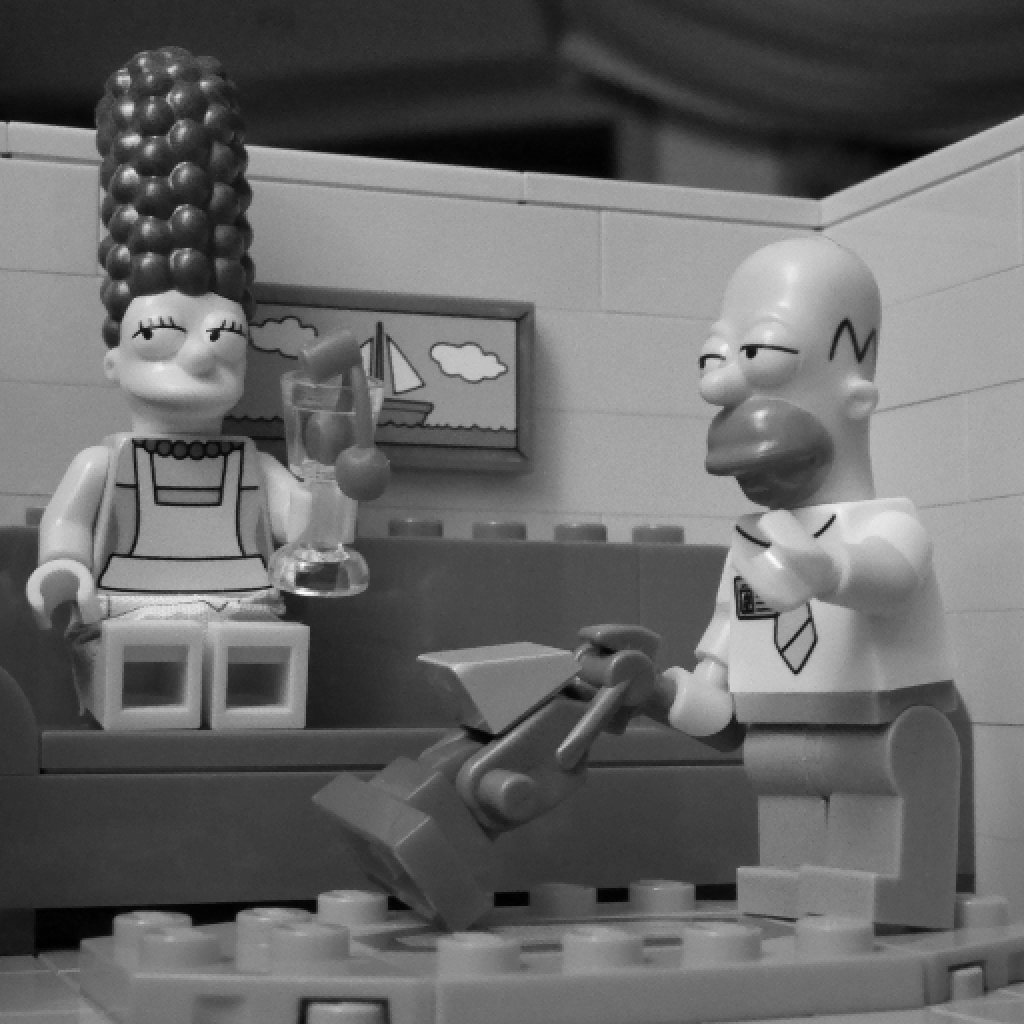

In [2]:
# Open the image
u0 = torch.tensor(rgb2gray(plt.imread('im/simpson512.png')))
M,N = u0.shape

viewimage(u0)

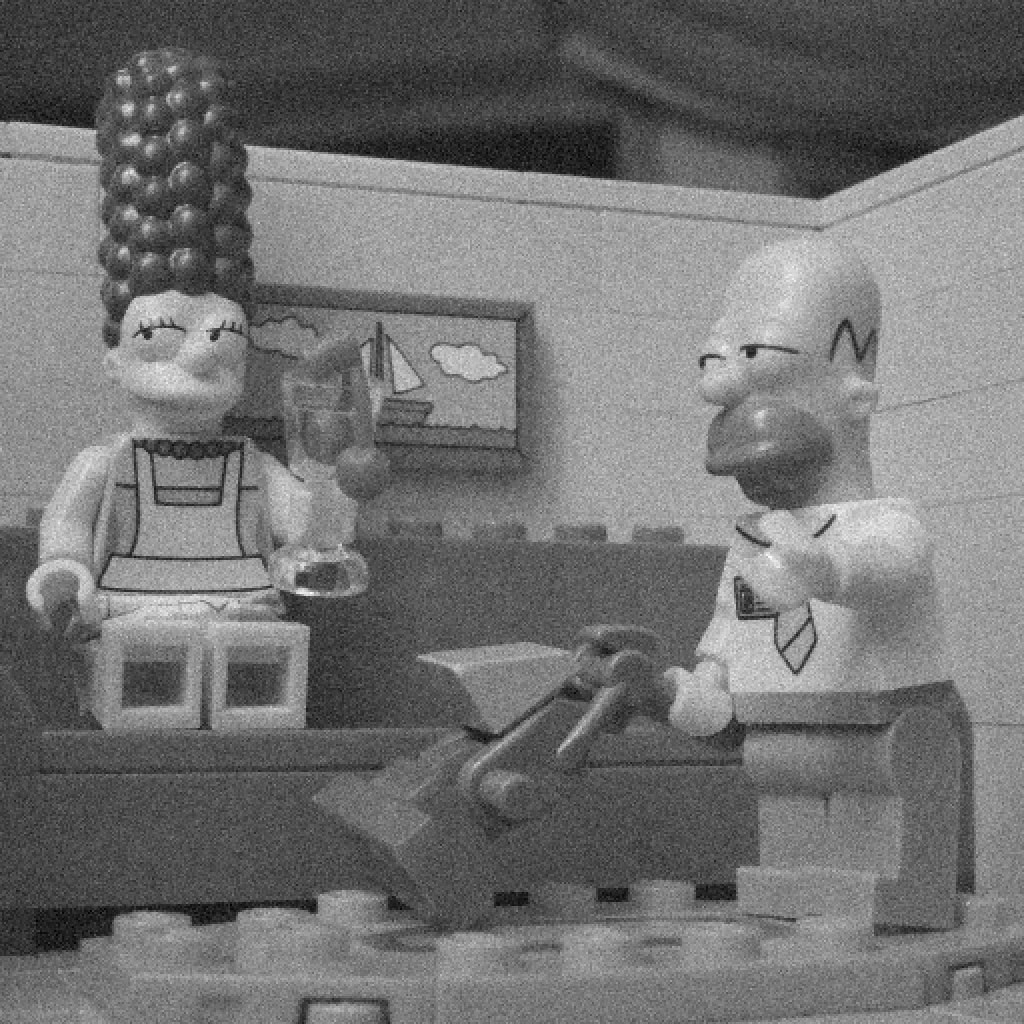

In [3]:
sigma = .05
z = u0 + sigma*torch.randn((M, N))

viewimage(z)

In [70]:
def Dstar(pbar_k):
    ret = torch.zeros((M, N), dtype=torch.double)
    ret[1:] += pbar_k[:-1, :, 0]
    ret[:-1] -= pbar_k[:-1, :, 0]
    ret[:, 1:] += pbar_k[:, 1:, 1]
    ret[:, :-1] -= pbar_k[:, :-1, 1]
    return ret

def D(x):
    ret = torch.zeros((M, N, 2), dtype=torch.double)
    ret[:-1, :, 0] = x[1:] - x[:-1]
    ret[:, :-1, 1] = x[:, 1:] - x[:, :-1]
    return ret

def prox_tauk_g(v, z, sigma, tau_k):
    return 1/(1+tau_k/sigma**2)*(tau_k/sigma**2*z + v)

def prox_sigmak_fstar(v, s_k, lamb):
    return torch.minimum(torch.tensor(1/lamb, dtype=v.dtype), torch.maximum(torch.tensor(-1/lamb, dtype=v.dtype), v))

def ulpda(z, x0, p0, sigma, lamb, s_k, tau_k, theta_k, K=1000, burnin=500):
    """
    Unadjusted Langevin primal-dual algorithm for TV-l2 regularisation.

    Parameters
    ----------
    x0 : (M, N) numpy.ndarray
        Initial image sample.
    p0 : (M, N, 2) numpy.ndarray
        Initial auxiliary vector.
    sigma : float
        Standard deviation of the noise added to the image.
    s_k : float
        $\\sigma_k$.
    tau_k : float
        $\\tau_k$.
    theta_k : float
        $\\theta_k$.
    """
    x = x0.detach().clone()
    p = p0.detach().clone()
    p_prev = None
    xhat = torch.zeros_like(x0)
    count = 0
    M2 = torch.zeros_like(x0)
    for k in range(K):
        pbar_k = p if k==0 else p + theta_k*(p-p_prev)
        v = x - tau_k*Dstar(pbar_k)
        xi_k = torch.randn(x.size())
        x = prox_tauk_g(v, z, sigma, tau_k) + (2*tau_k)**.5*xi_k
        p_prev = p
        p = prox_sigmak_fstar(p + s_k*D(x), s_k, lamb)
        if k >= burnin:
            count += 1
            delta = x-xhat
            xhat += delta/count
            delta2 = x-xhat
            M2 += delta*delta2
    return xhat, M2/count

In [74]:
x0 = torch.randn((M, N))
p0 = torch.randn((M, N, 2))
lamb = 0.05
xhat, variances = ulpda(z, x0, p0, sigma, lamb, 1, 1e-4, .1, K=2000, burnin=1000)

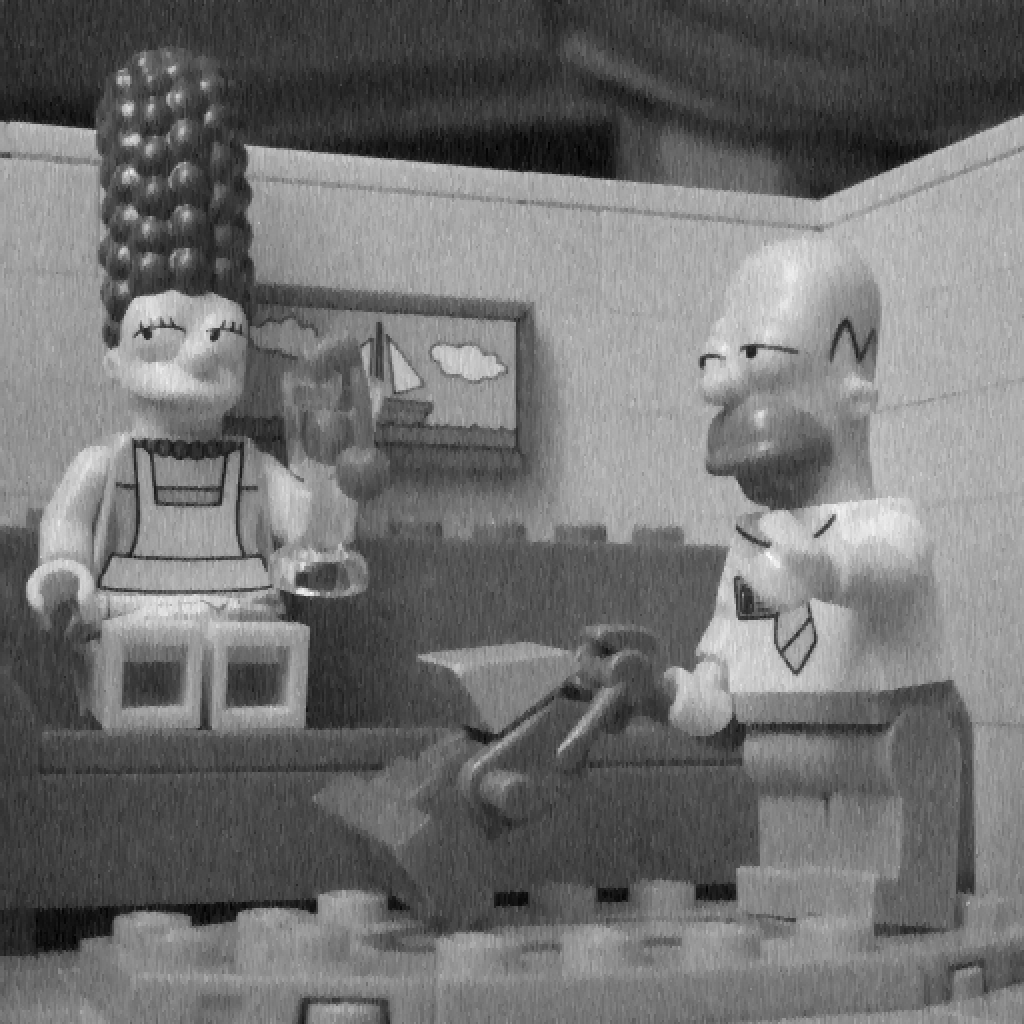

In [75]:
viewimage(xhat)

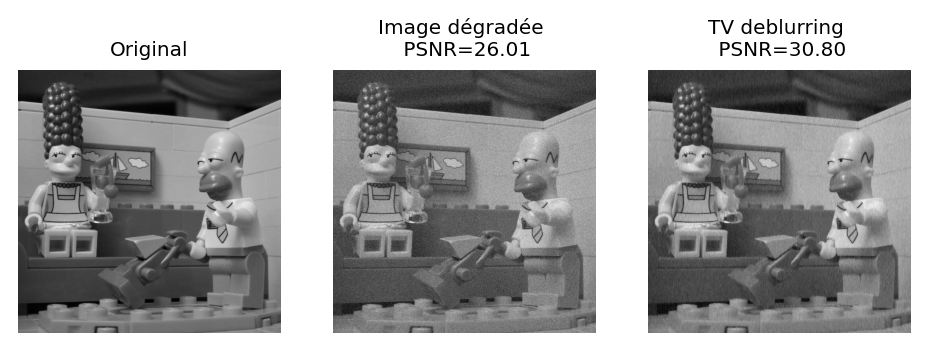

In [76]:
plt.figure(dpi=180)
plt.subplot(1,3,1)
plt.imshow(u0, cmap='gray')
plt.title('Original',fontsize=8)
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(z, cmap='gray')
plt.title('Image dégradée \n PSNR='+str2(psnr(u0,z)),fontsize=8)
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(xhat, cmap='gray')
plt.title('TV deblurring \n PSNR='+str2(psnr(u0,xhat)),fontsize=8)
plt.axis('off')
plt.show()

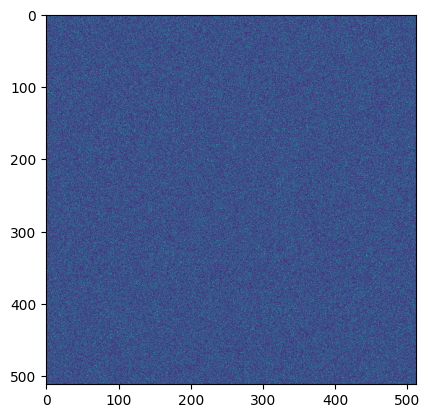

(array([2.0000e+00, 3.0000e+01, 1.5700e+02, 7.2700e+02, 2.7540e+03,
        7.9500e+03, 1.7412e+04, 3.0513e+04, 4.3644e+04, 4.9774e+04,
        4.4955e+04, 3.2609e+04, 1.8649e+04, 8.6750e+03, 3.1350e+03,
        9.0700e+02, 2.1100e+02, 3.6000e+01, 3.0000e+00, 1.0000e+00]),
 array([-3.03824329, -2.99276829, -2.94729328, -2.90181804, -2.85634303,
        -2.81086802, -2.76539302, -2.71991801, -2.67444277, -2.62896776,
        -2.58349276, -2.53801775, -2.49254274, -2.4470675 , -2.40159249,
        -2.35611749, -2.31064248, -2.26516747, -2.21969223, -2.17421722,
        -2.12874222]),
 <BarContainer object of 20 artists>)

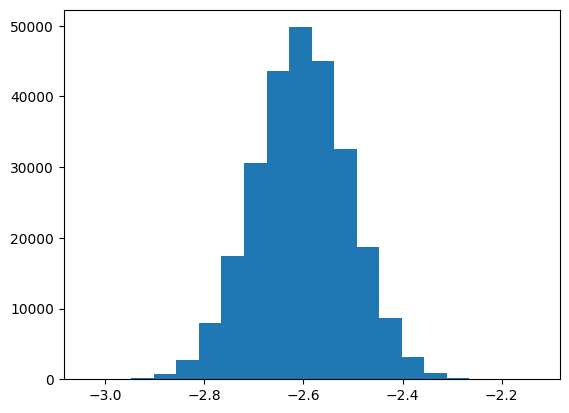

In [77]:
plt.imshow(variances)
plt.show()
plt.hist(np.log10(variances.flatten()), bins=20)

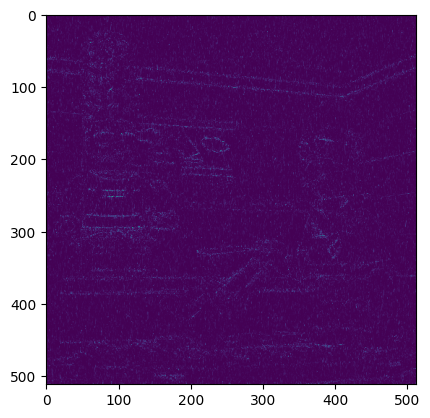

In [78]:
errors = (xhat-u0)**2
plt.imshow(errors)

In [79]:
nbins = 100
var_max = .01
bin_step = var_max/nbins
errors_per_bin = [[] for _ in range(nbins)]
for i in range(M):
    for j in range(N):
        bin = min(nbins-1, int(variances[i, j]/bin_step))
        errors_per_bin[bin].append(errors[i, j])
for bin in range(nbins):
    errors_per_bin[bin].sort()

In [80]:
print(list(map(len, errors_per_bin)))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 20, 65, 251, 641, 1553, 3013, 5000, 7572, 10221, 13020, 15459, 17674, 18916, 19609, 19649, 18638, 17420, 15545, 13989, 12249, 10103, 8543, 7053, 5656, 4624, 3684, 2852, 2259, 1684, 1312, 968, 775, 554, 393, 326, 225, 171, 122, 92, 63, 42, 36, 28, 30, 13, 11, 8, 2, 4, 2, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


/home/victor/python-venvs/mva/lib/python3.10/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/victor/python-venvs/mva/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


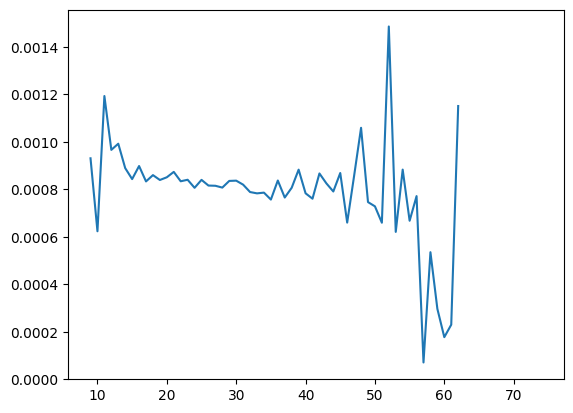

In [81]:
plt.plot(list(map(np.average, errors_per_bin)))